In [3]:
from pathlib import Path

from PIL import Image
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
# from unet import AttUNet, UNet, UNetWithPretrainedEncoder
# from dataloader import ImageDataset, TransformWrapper
import os
import random
from random import shuffle
import numpy as np
import torch
from torch.utils import data
from torchvision import transforms as T
import torchvision.transforms.functional as F

from PIL import Image
from PIL.ImageFile import ImageFile

from pathlib import Path

from PIL import Image
import numpy as np
import cv2

class TransformWrapper:

    def __init__(self):
        self.image_transforms = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
            T.RandomRotation(degrees=[30, 60, 90, 120, 150]),
            T.ToTensor(),
        ])

        self.mask_transforms = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
            T.RandomRotation(degrees=45),
            T.ToTensor(),
        ])

    def __call__(self, image, mask):
        # Apply the same random seed to ensure consistent transformations
        seed = torch.randint(0, 2**32, (1, )).item()
        torch.manual_seed(seed)
        image = self.image_transforms(image)

        torch.manual_seed(seed)
        mask = self.mask_transforms(mask)

        return image, mask


class ImageDataset(Dataset):

    def __init__(self,
                 images: list[ImageFile],
                 masks: list[ImageFile],
                 transform: bool = False,
                 image_size: int = 224):

        self.images = images
        self.masks = masks
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self,
                    index) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        image = self.images[index]
        mask = self.masks[index]

        image = image.resize((self.image_size, self.image_size),
                             Image.Resampling.LANCZOS)
        mask = mask.resize((self.image_size, self.image_size),
                           Image.Resampling.LANCZOS)

        image = apply_clahe(image)
        image = T.GaussianBlur(3)(image)

        mask = mask.convert("L")  # Ensure mask is in grayscale
        binary_threshold = 100  # Adjust this threshold as needed
        mask = mask.point(lambda p: 255 if p > binary_threshold else 0)
        mask = mask.convert('1')
        

        normalize_tensor = T.Compose([
            T.Lambda(lambda x: x.convert("RGB")),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            T.Lambda(lambda x: x),
        ])

        if self.transform:
            angle = random.uniform(-90, 90)
            
            image = F.rotate(image, angle)
            image = normalize_tensor(image)
            mask = T.ToTensor()(F.rotate(mask, angle))
            return image, mask

        return normalize_tensor(image), T.ToTensor()(mask)

data_pth = Path('/Users/tsakalis/ntua/cellforge/data/inner_embryo_data')
blastocyst_pth = Path('/Users/tsakalis/ntua/cellforge/data/annotation_pn')

blastocyst_images_pth = blastocyst_pth / 'images_pn'
blastocyst_msk_pth = blastocyst_pth / 'masks_pn'

smooth = 1e-15

device = 'cuda'


def dice_coef(y_pred, y_true):

    intersection = torch.sum(y_true.flatten() * y_pred.flatten())
    return (2. * intersection + smooth) / (
        torch.sum(y_true).flatten() + torch.sum(y_pred).flatten() + smooth)


def dice_loss(y_pred, y_true):

    return 1.0 - dice_coef(y_true, y_pred)


In [4]:
blastocyst_msk_pth

PosixPath('/Users/tsakalis/ntua/cellforge/data/annotation_pn/masks_pn')

In [5]:
blastocyst_images = []
blastocyst_masks = []
for embry_pth in blastocyst_msk_pth.glob('*'):
    for mask_pth in embry_pth.glob('*.png'):
        msk_img = Image.open(mask_pth)
        try:
            raw_img = Image.open(
                blastocyst_images_pth /
                f"{embry_pth.name.upper()}/{mask_pth.stem}.jpg")
            blastocyst_images.append(raw_img)
            blastocyst_masks.append(msk_img)
        except Exception as e:
            print(e)
            continue


In [6]:
image_file_paths = sorted(list((data_pth / "images").glob('*.jpg')),
                          key=lambda x: x.stem)
mask_file_paths = sorted(list((data_pth / "masks").glob('*.png')),
                         key=lambda x: x.stem)


In [13]:
len(image_file_paths)

0

In [7]:
image_file_paths = sorted(list((data_pth / "images").glob('*.jpg')),
                          key=lambda x: x.stem)
mask_file_paths = sorted(list((data_pth / "masks").glob('*.png')),
                         key=lambda x: x.stem)

# print("... Loading images ...")
images = [Image.open(img_path) for img_path in tqdm(image_file_paths)]
masks = [Image.open(msk_pth) for msk_pth in tqdm(mask_file_paths)]

train_dataset = ImageDataset(images=images[:600],
                             masks=masks[:600],
                             transform=True)
val_dataset = ImageDataset(images=images[600:800], masks=masks[600:800])

train_dataloader = DataLoader(train_dataset, batch_size=8)

val_dataloader = DataLoader(val_dataset, batch_size=16)


0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [8]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name=
    "resnext101_32x16d",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=
    "instagram",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=
    3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset)
)

model = model.half()
model.to(device)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 5

/home/tsakalis/ntua/phd/cellforge/cellforge_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import torch


def validate(model, val_dataloader):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for img_batch, gt_msk_batch in val_dataloader:

            img_batch = img_batch.to(device)
            gt_msk_batch = gt_msk_batch.to(device)

            pred_mask = model(img_batch)

            loss = dice_loss(torch.sigmoid(pred_mask), gt_msk_batch)

            val_loss += loss.item()

    mean_val_loss = val_loss / len(val_dataloader)
    return mean_val_loss


In [10]:
model.half()


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

In [11]:
for epoch in range(n_epochs):
    progress_bar = tqdm(train_dataloader, total=len(train_dataloader))

    train_loss = 0
    for img_batch, gt_msk_batch in progress_bar:

        optimizer.zero_grad()
        pred_mask = model(img_batch.half().to(device))

        loss = dice_loss(torch.sigmoid(pred_mask), gt_msk_batch.half().to(device))
        loss.backward()
        optimizer.step()

        progress_bar.set_description(str(loss.item()))

        train_loss += loss.item()

    val_loss = validate(model, val_dataloader)

    print(
        f'Epoch {epoch+1} | TrainLoss: {train_loss/len(train_dataloader)} ValLoss: {val_loss}'
    )

0it [00:00, ?it/s]


ZeroDivisionError: division by zero

In [12]:
val_dataloader

In [37]:
model.eval()
for img_batch, gt_msk_batch in val_dataloader:

    pred_msk = model(img_batch.to(device))
    continue

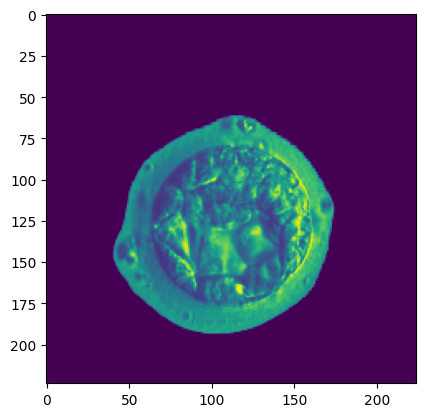

In [40]:
plt.imshow(
    torch.sigmoid(img_batch)[6, :].to('cpu').detach().numpy().T *
    torch.sigmoid(pred_msk)[6, :].to('cpu').detach().numpy().T)

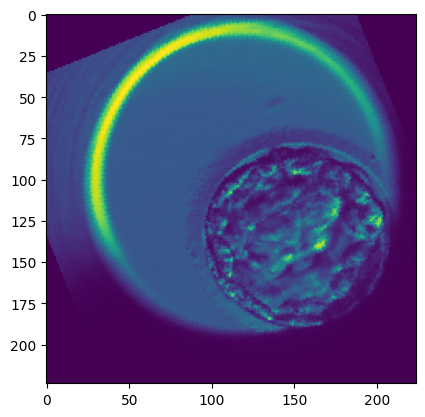

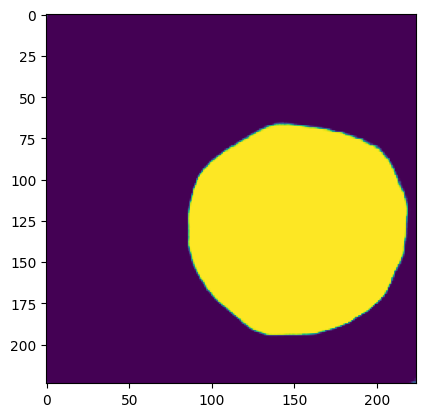

In [16]:
import matplotlib.pyplot as plt

plt.imshow(torch.sigmoid(img_batch)[5, :].to('cpu').detach().numpy().T)
plt.show()
plt.imshow(torch.sigmoid(pred_msk)[5, :].to('cpu').detach().numpy().T)

In [20]:
 validate(model, val_dataloader)

Validating...:  10%|█         | 1/10 [00:08<01:20,  8.95s/it]


RuntimeError: MPS backend out of memory (MPS allocated: 16.87 GB, other allocations: 1.09 GB, max allowed: 18.13 GB). Tried to allocate 196.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).